###THE CODE STARTS HERE###

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Load and Inspect Dataset
df = pd.read_csv("user_behavior_dataset.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [ ]:
# Preprocessing & Feature Engineering

# Drop unnecessary columns
df = df.drop(columns=['User ID', 'User Behavior Class'])

# Convert screen time from hours to minutes
df['Screen On Time (min/day)'] = df['Screen On Time (hours/day)'] * 60

# Create normalized and ratio-based features
df['Battery per Minute'] = (df['Battery Drain (mAh/day)'] / df['Screen On Time (min/day)']).round(3)
df['Data per Minute'] = (df['Data Usage (MB/day)'] / df['Screen On Time (min/day)']).round(3)
df['App Usage Ratio'] = (df['App Usage Time (min/day)'] / df['Screen On Time (min/day)']).round(3)
df['Apps per Hour'] = (df['Number of Apps Installed'] / df['Screen On Time (hours/day)']).round(3)
df['Battery per Hour'] = (df['Battery Drain (mAh/day)'] / df['Screen On Time (hours/day)']).round(3)

# Binary feature: Battery Intensive (above median)
battery_threshold = df['Battery per Minute'].median()
df['Battery Intensive'] = (df['Battery per Minute'] > battery_threshold).astype(int)

# Age groups by decade
df['Age Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 70, 100], right=False,
                         labels=["<20", "20s", "30s", "40s", "50s", "60s", "70+"])

# Binary encoding for Gender and OS
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Operating System'] = df['Operating System'].map({'Android': 0, 'iOS': 1})

# Round engineered features to 3 decimal places
features_to_round = [
    'Screen On Time (min/day)', 'Battery per Minute', 'Data per Minute',
    'App Usage Ratio', 'Apps per Hour', 'Battery per Hour'
]
df[features_to_round] = df[features_to_round].round(3)

# Final list of numeric and categorical features
numeric_features = [
    'App Usage Time (min/day)', 'Screen On Time (min/day)',
    'Battery Drain (mAh/day)', 'Number of Apps Installed',
    'Data Usage (MB/day)', 'Age', 'Battery per Hour',
    'Battery per Minute', 'Data per Minute', 'App Usage Ratio', 'Apps per Hour'
]

categorical_features = ['Gender', 'Operating System', 'Battery Intensive', 'Age Group']

# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [ ]:
df.head(100)


,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,Screen On Time (min/day),Battery per Minute,Data per Minute,App Usage Ratio,Apps per Hour,Battery per Hour,Battery Intensive,Age Group
0,Google Pixel 5,0,393,6.4,1872,67,1122,40,0,384.0,4.875,2.922,1.023,10.469,292.500,0,40s
1,OnePlus 9,0,268,4.7,1331,42,944,47,1,282.0,4.720,3.348,0.950,8.936,283.191,0,40s
2,Xiaomi Mi 11,0,154,4.0,761,32,322,42,0,240.0,3.171,1.342,0.642,8.000,190.250,0,40s
3,Google Pixel 5,0,239,4.8,1676,56,871,20,0,288.0,5.819,3.024,0.830,11.667,349.167,1,20s
4,iPhone 12,1,187,4.3,1367,58,988,31,1,258.0,5.298,3.829,0.725,13.488,317.907,1,30s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Xiaomi Mi 11,0,326,7.2,2243,73,1454,50,0,432.0,5.192,3.366,0.755,10.139,311.528,1,50s
96,iPhone 12,1,550,9.5,2916,91,1946,20,0,570.0,5.116,3.414,0.965,9.579,306.947,1,20s
97,OnePlus 9,0,516,12.0,2406,82,1968,28,1,720.0,3.342,2.733,0.717,6.833,200.500,0,20s
98,Google Pixel 5,0,59,1.2,361,18,293,25,1,72.0,5.014,4.069,0.819,15.000,300.833,1,20s


In [ ]:
# Export the Data with Cluster Labels
df.to_csv("cleaned_data.csv", index=False)


Silhouette Score: 0.221


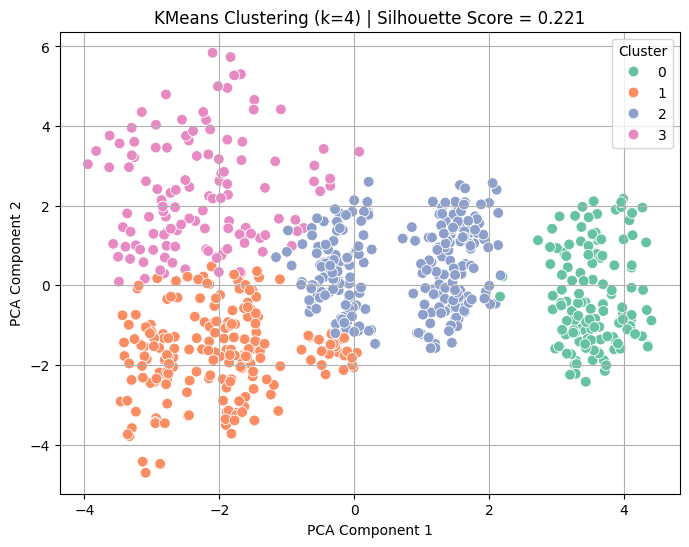

In [ ]:
# Build pipeline with KMeans
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=4, init='k-means++', random_state=42))
])

# Fit pipeline
clustering_pipeline.fit(df)
df['Cluster'] = clustering_pipeline.named_steps['cluster'].labels_

# Evaluate clustering
X_transformed = clustering_pipeline.named_steps['preprocessor'].transform(df)
sil_score = silhouette_score(X_transformed, df['Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2', s=60)
plt.title(f'KMeans Clustering (k=4) | Silhouette Score = {sil_score:.3f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


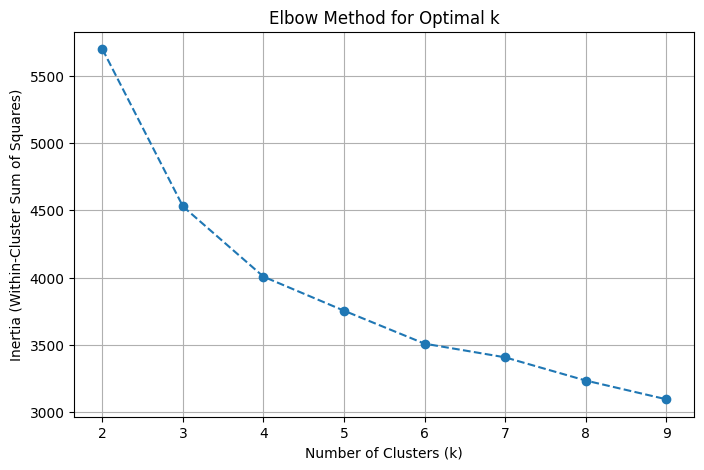

In [ ]:
# Run Elbow Method to determine optimal number of clusters (k)
inertia_scores = []
k_range = range(2, 10)

for k in k_range:
    elbow_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', KMeans(n_clusters=k, init='k-means++', random_state=42))
    ])
    elbow_pipeline.fit(df)
    inertia = elbow_pipeline.named_steps['cluster'].inertia_
    inertia_scores.append(inertia)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
df.columns.tolist()


['Device Model',
 'Operating System',
 'App Usage Time (min/day)',
 'Screen On Time (hours/day)',
 'Battery Drain (mAh/day)',
 'Number of Apps Installed',
 'Data Usage (MB/day)',
 'Age',
 'Gender',
 'Screen On Time (min/day)',
 'Battery per Minute',
 'Data per Minute',
 'App Usage Ratio',
 'Apps per Hour',
 'Battery per Hour',
 'Battery Intensive',
 'Age Group',
 'Cluster']

In [ ]:
# Group statistics by cluster
cluster_summary = df.groupby('Cluster')[numeric_features].mean().round(2)
print(cluster_summary)


         App Usage Time (min/day)  Screen On Time (min/day)  \
Cluster                                                       
0                          540.20                    604.96   
1                          114.81                    181.00   
2                          326.73                    358.70   
3                          106.58                    121.75   

         Battery Drain (mAh/day)  Number of Apps Installed  \
Cluster                                                      
0                        2695.38                     88.97   
1                         750.72                     26.82   
2                        1838.26                     61.16   
3                         820.59                     24.71   

         Data Usage (MB/day)    Age  Battery per Hour  Battery per Minute  \
Cluster                                                                     
0                    1967.52  38.11            270.83                4.51   
1                

In [ ]:
print(df['Cluster'].value_counts())

Cluster
2    244
1    198
0    138
3    120
Name: count, dtype: int64


In [ ]:
print(df.groupby('Cluster')[['Gender', 'Operating System', 'Age']].mean())

           Gender  Operating System        Age
Cluster                                       
0        0.442029          0.224638  38.108696
1        0.469697          0.196970  40.222222
2        0.520492          0.217213  38.700820
3        0.458333          0.191667  35.600000


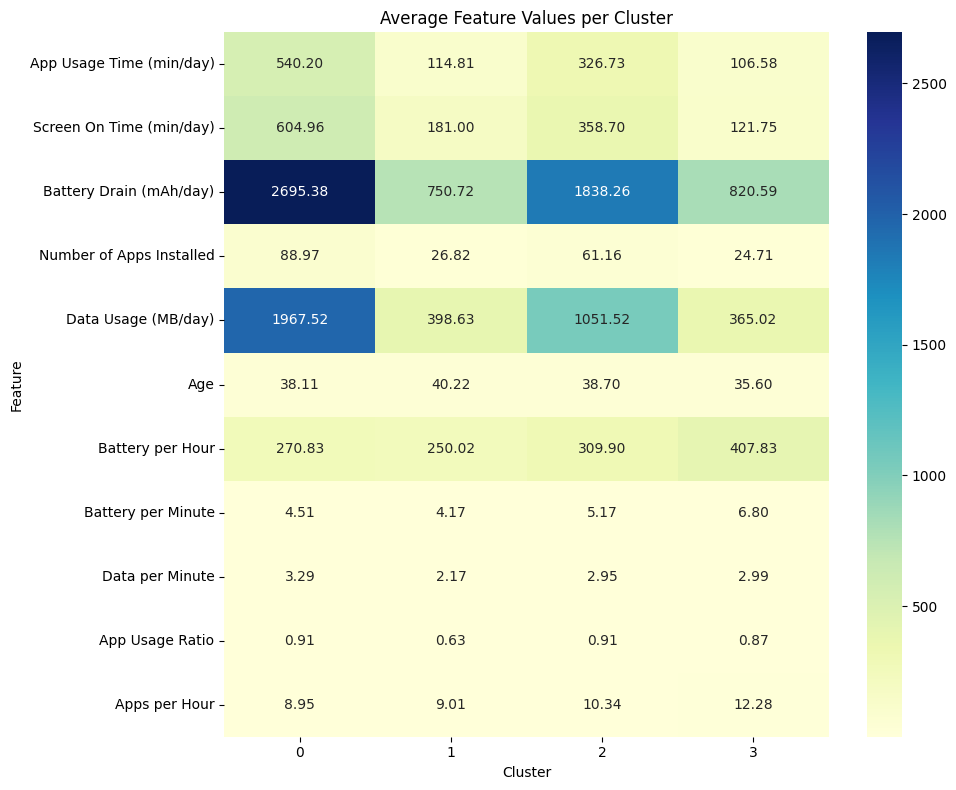

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, annot=True, cmap="YlGnBu", fmt=".2f")  # Transpose the dataframe
plt.title("Average Feature Values per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("cluster_feature_heatmap.png")
plt.show()


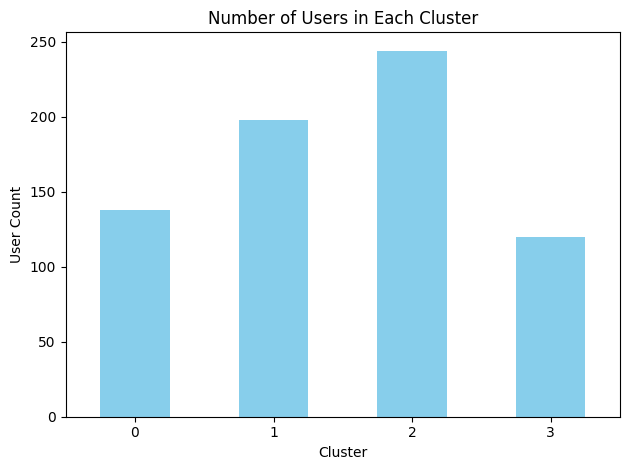

In [ ]:
df['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of Users in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("User Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("cluster_sizes.png")
plt.show()


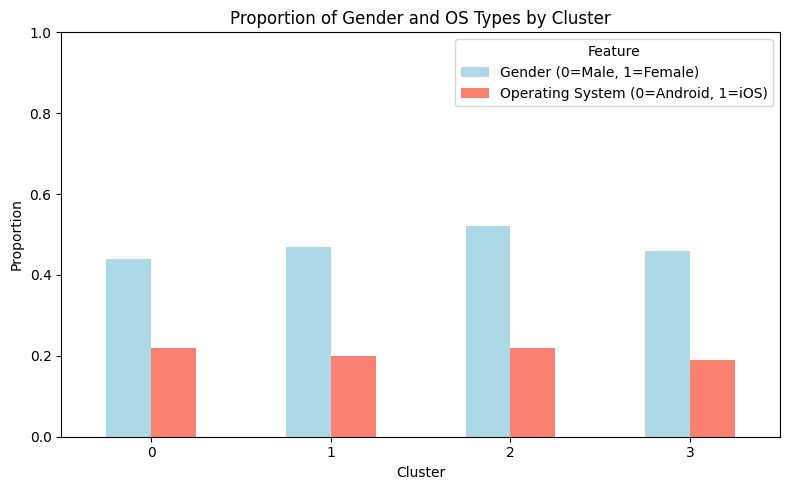

In [ ]:
binary_means = demographic_means[['Gender', 'Operating System']]
ax = binary_means.plot(kind='bar', figsize=(8,5), ylim=(0, 1), color=['lightblue', 'salmon'])

plt.title("Proportion of Gender and OS Types by Cluster")
plt.ylabel("Proportion")
plt.xticks(rotation=0)

# Custom legend with binary value meaning
handles, labels = ax.get_legend_handles_labels()
custom_labels = ['Gender (0=Male, 1=Female)', 'Operating System (0=Android, 1=iOS)']
plt.legend(handles, custom_labels, title='Feature')

plt.tight_layout()
plt.savefig("cluster_demographics_binary_labeled.png")
plt.show()




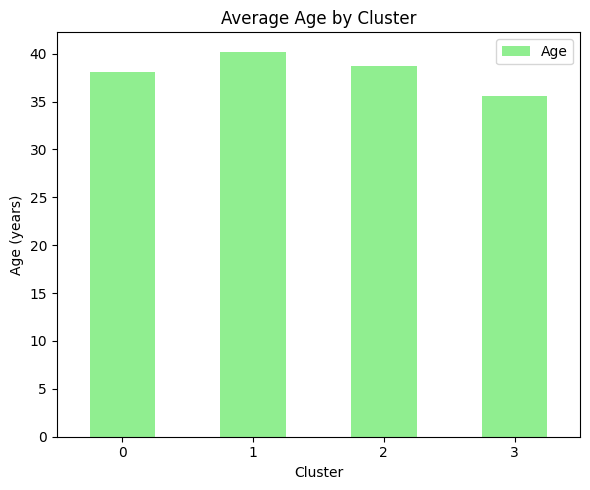

In [ ]:
age_means = demographic_means[['Age']]
age_means.plot(kind='bar', figsize=(6,5), color='lightgreen')
plt.title("Average Age by Cluster")
plt.ylabel("Age (years)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("cluster_age.png")
plt.show()
